# Content-Based Recommender System
### By: John Desiderio

In [1]:
import sys 
import pandas as pd
# Import functions
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender


print(f"System version: {sys.version}")

System version: 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]


In [2]:
# Load movies metadata
metadata = pd.read_csv('./data/movies_metadata.csv', low_memory=False)

metadata.head(3)

metadata['overview'] = metadata['overview'].fillna('')

# load credits and keywords
credits = pd.read_csv('./data/credits.csv')
keywords = pd.read_csv('./data/keywords.csv')

# remove rows with bad ids
metadata = metadata.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [3]:
metadata.shape

(46628, 27)

In [4]:
_list = []
for index, row in metadata.iterrows():
    if row['vote_count'] >= 25.0:
        _list.append(row)
        
len(_list)

14046

In [5]:
filter_ = metadata['vote_count'] >= 25.0
metadata = metadata[filter_]
print(metadata.shape)

(14046, 27)


<AxesSubplot:title={'center':'Released?'}>

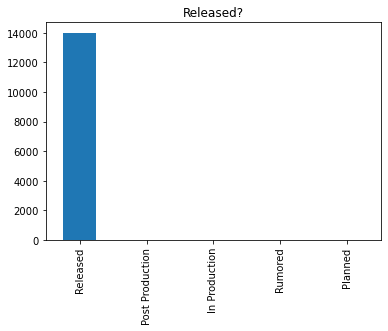

In [6]:
metadata['status'].value_counts().plot(kind='bar', title='Released?')

In [7]:
print("Number of movies we are working with: " + str(len(metadata)))

Number of movies we are working with: 14046


In [8]:
import numpy as np

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
    
    # Return empty list in case of missing/malformed data
    return []

In [9]:
from ast import literal_eval

# Parse the stringified feature into their corresponding python objects
features = ["cast", "crew", "keywords", "genres"]
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

# Define new director, cast, genres, and keywords feature that are in a suitable form
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)
    
# Print the new featuers of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [10]:
# Function to convert all string to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    else:
        # Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(' ', ''))
        else:
            return ''

In [11]:
# Apply clean)data function to your features
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)
    
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

# Create new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

metadata[['soup']].head(2)

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...


In [12]:
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildren'sbook ...


In [13]:
# Define the recommender lol
recommender = TfidfRecommender(id_col='id', tokenization_method='none')


# Assign columns to clean and combine
cols_to_clean = ['soup']
clean_col = 'soup'


df_clean = recommender.clean_dataframe(metadata, cols_to_clean, clean_col)

In [14]:
# df_clean = df_clean.drop('cleaned_text', axis=1)
print(df_clean.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'director',
       'soup'],
      dtype='object')


In [15]:
df_clean = df_clean[['genres', 'id','overview','title','cast','crew','keywords','director','soup']]

df_clean.head(2)

,genres,id,overview,title,cast,crew,keywords,director,soup
0,"[animation, comedy, family]",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,"[adventure, fantasy, family]",8844,When siblings Judy and Peter discover an encha...,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildrensbook r...


In [16]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)

In [18]:
# Needed to find specific movies to compile a list for looking for recommendations
for index, row in df_clean.iterrows():
    if row['director'] == 'jimjarmusch':
        print(row['title'] + '\t\t\t' + str(row['id']))

Dead Man			922
Down by Law			1554
Night on Earth			339
Ghost Dog: The Way of the Samurai			4816
Mystery Train			11305
Stranger Than Paradise			469
Permanent Vacation			37997
Coffee and Cigarettes			883
Broken Flowers			308
The Limits of Control			8284
Only Lovers Left Alive			152603
Paterson			370755
Gimme Danger			392820


In [71]:
# idk how to spell some directors names
for index, row in metadata.iterrows():
    if row['title'] == 'Apocalypto':
        print(row['id'])

1579


In [20]:
fav_movies = ['The Departed', 'Brazil', 'The Game', 'Rear Window', 'Bottle Rocket', 'Eraserhead', 'Fargo', 'Requiem for a Dream', 'Crimes and Misdemeanors', 'Night on Earth']
for index, row in df_clean.iterrows():
    if row['title'] in fav_movies:
        print(f"{row['title']} id is {row['id']}")

Bottle Rocket id is 13685
Fargo id is 275
Rear Window id is 567
Brazil id is 68
Night on Earth id is 339
The Game id is 2649
Crimes and Misdemeanors id is 11562
Eraserhead id is 985
Requiem for a Dream id is 641
The Departed id is 1422


In [21]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

# Recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=5)

In [22]:
# Preview the recommender recommendations
top_k_recommendations

,id,rec_rank,rec_score,rec_id
0,862,1,0.279761,863
1,862,2,0.171057,13927
2,862,3,0.171057,13926
3,862,4,0.156793,213121
4,862,5,0.155101,130925
...,...,...,...,...
68985,30840,1,0.144870,362136
68986,30840,2,0.144446,37737
68987,30840,3,0.131973,16535
68988,30840,4,0.123523,7515


In [23]:
type(top_k_recommendations)

pandas.core.frame.DataFrame

In [24]:
# Optionally view full recommendations list
full_rec_list = recommender.recommendations


In [25]:
# Check out the number of recommended movies for one movie
print('Number of recommended articles for ' + '21786' + ': ' + str(len(full_rec_list[13685])))

Number of recommended articles for 21786: 14045


In [26]:
# Optionally view tokens
tokens = recommender.get_tokens()

# Preview 10 tokens
print(list(tokens.keys())[:10])

['jealousy', 'toy', 'boy', 'tomhanks', 'timallen', 'donrickles', 'johnlasseter', 'animation', 'comedy', 'family']


In [27]:
# Preview the first 10 stop words alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


In [28]:
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director']
# Example recommendations for the movie 'To Die For'
recommender.get_top_k_recommendations(metadata, 577, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.089772,"[fantasy, drama, comedy]","In Manhattan, the aspirant writer Jabez Stone ...",Shortcut to Happiness,"[anthonyhopkins, alecbaldwin, jenniferlovehewitt]","[{'credit_id': '52fe45449251416c9102c7ed', 'de...",[],alecbaldwin
1,2,0.083071,"[fantasy, drama, comedy]",Roger is a foster child whose irresponsible fa...,Angels in the Outfield,"[dannyglover, brendafricker, josephgordon-levitt]","[{'credit_id': '52fe44aac3a368484e02fd0f', 'de...",[baseball],williamdear
2,3,0.082862,"[fantasy, drama, comedy]",A businessman is reunited with the four lost s...,Heart and Souls,"[robertdowneyjr., charlesgrodin, kyrasedgwick]","[{'credit_id': '52fe44c79251416c75040a5f', 'de...",[afterlife],ronunderwood
3,4,0.074910,"[fantasy, drama, comedy]",Henry Van Cleve presents himself at the gates ...,Heaven Can Wait,"[genetierney, donameche, charlescoburn]","[{'credit_id': '52fe47959251416c7509ea95', 'de...","[hell, devil]",ernstlubitsch
4,5,0.073730,"[fantasy, drama, comedy]","A couple of angels, O'Reilly and Jackson, are ...",A Life Less Ordinary,"[ewanmcgregor, camerondiaz, hollyhunter]","[{'credit_id': '52fe4490c3a36847f809d499', 'de...","[angel, sex, robbery]",dannyboyle


In [29]:
movies_of_interest = ['The Departed', 'Brazil', 'The Game', 'Rear Window', 'Bottle Rocket', 'Eraserhead', 'Fargo', 'Requiem for a Dream', 'Crimes and Misdemeanors', 'Night on Earth']
df_test = pd.DataFrame(columns=metadata.columns)

row_index = [index for index, row in metadata.iterrows() if row['title'] in movies_of_interest]

len(row_index)

10

In [30]:
for i in range(len(row_index)):
    df_test.loc[i] = metadata.loc[row_index[i]] 

In [31]:
df_test

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,False,NaN,7000000,"[comedy, crime, drama]",NaN,13685,tt0115734,en,Bottle Rocket,Upon his release from a mental hospital follow...,...,"They're not really criminals, but everyone's g...",Bottle Rocket,False,6.8,285.0,"[lukewilson, owenwilson, lumicavazos]","[{'credit_id': '52fe458b9251416c7505a35b', 'de...","[brotherbrotherrelationship, robbery, burglar]",wesanderson,brotherbrotherrelationship robbery burglar luk...
1,False,NaN,7000000,"[crime, drama, thriller]",http://www.themoviefargo.com/,275,tt0116282,en,Fargo,"Jerry, a small-town Minnesota car salesman is ...",...,A lot can happen in the middle of nowhere.,Fargo,False,7.7,2080.0,"[williamh.macy, francesmcdormand, stevebuscemi]","[{'credit_id': '52fe4231c3a36847f800af4d', 'de...","[cheating, ransom, salesclerk]",joelcoen,cheating ransom salesclerk williamh.macy franc...
2,False,NaN,1000000,"[drama, mystery, thriller]",NaN,567,tt0047396,en,Rear Window,"Professional photographer L.B. ""Jeff"" Jeffries...",...,It only takes one witness to spoil the perfect...,Rear Window,False,8.2,1531.0,"[jamesstewart, gracekelly, wendellcorey]","[{'credit_id': '52fe4253c3a36847f80157fd', 'de...","[nurse, photographer, suspicionofmurder]",alfredhitchcock,nurse photographer suspicionofmurder jamesstew...
3,False,NaN,15000000,"[comedy, sciencefiction]",NaN,68,tt0088846,en,Brazil,Low-level bureaucrat Sam Lowry escapes the mon...,...,It's only a state of mind.,Brazil,False,7.6,877.0,"[jonathanpryce, robertdeniro, katherinehelmond]","[{'credit_id': '52fe4213c3a36847f8001e6d', 'de...","[bureaucracy, policestate, terror]",terrygilliam,bureaucracy policestate terror jonathanpryce r...
4,False,NaN,3500000,"[comedy, drama]",NaN,339,tt0102536,en,Night on Earth,An anthology of 5 different cab drivers in 5 A...,...,Five Taxis. Five Cities. One Night.,Night on Earth,False,7.5,165.0,"[winonaryder, genarowlands, lisannefalk]","[{'credit_id': '52fe423ac3a36847f800daab', 'de...","[paris, newyork, taxi]",jimjarmusch,paris newyork taxi winonaryder genarowlands li...
5,False,NaN,50000000,"[drama, thriller, mystery]",NaN,2649,tt0119174,en,The Game,"In honor of his birthday, San Francisco banker...",...,What do you get for the man who has everything?,The Game,False,7.5,1556.0,"[michaeldouglas, seanpenn, deborahkaraunger]","[{'credit_id': '52fe4362c3a36847f80506b7', 'de...","[brotherbrotherrelationship, birthday, dangero...",davidfincher,brotherbrotherrelationship birthday dangerofli...
6,False,NaN,19000000,"[comedy, drama]",NaN,11562,tt0097123,en,Crimes and Misdemeanors,An ophthalmologist's mistress threatens to rev...,...,A film about humanity.,Crimes and Misdemeanors,False,7.4,201.0,"[woodyallen, martinlandau, anjelicahuston]","[{'credit_id': '52fe445a9251416c75031c55', 'de...","[newyork, adultery, assassin]",woodyallen,newyork adultery assassin woodyallen martinlan...
7,False,NaN,10000,"[drama, fantasy, horror]",NaN,985,tt0074486,en,Eraserhead,Henry Spencer tries to survive his industrial ...,...,Where your nightmares end...,Eraserhead,False,7.5,500.0,"[jacknance, charlottestewart, allenjoseph]","[{'credit_id': '52fe4296c3a36847f802a5dd', 'de...","[baby, mutant, claustrophobia]",davidlynch,baby mutant claustrophobia jacknance charlotte...
8,False,NaN,4500000,"[crime, drama]",http://www.requiemforadream.com/,641,tt0180093,en,Requiem for a Dream,The hopes and dreams of four ambitious people ...,...,NaN,Requiem for a Dream,False,7.9,2525.0,"[ellenburstyn, jaredleto, jenniferconnelly]","[{'credit_id': '52fe4263c3a36847f801a72b', 'de...","[drugaddiction, junkie, heroin]",darrenaronofsky,drugaddiction junkie heroin ellenburstyn jared...
9,False,NaN,90000000,"[drama, thriller, crime]",http://thedeparted.warnerbros.com/,1422,tt0407887,en,The Departed,"To take down South Boston's Irish Mafia, the p...",...,Lies. Betrayal. Sacrifice. How

In [31]:
df_test = df_test[['genres', 'id','overview','title','cast','crew','keywords','director','soup']]
df_test

,genres,id,overview,title,cast,crew,keywords,director,soup
0,"[comedy, crime, drama]",13685,Upon his release from a mental hospital follow...,Bottle Rocket,"[lukewilson, owenwilson, lumicavazos]","[{'credit_id': '52fe458b9251416c7505a35b', 'de...","[brotherbrotherrelationship, robbery, burglar]",wesanderson,brotherbrotherrelationship robbery burglar luk...
1,"[crime, drama, thriller]",275,"Jerry, a small-town Minnesota car salesman is ...",Fargo,"[williamh.macy, francesmcdormand, stevebuscemi]","[{'credit_id': '52fe4231c3a36847f800af4d', 'de...","[cheating, ransom, salesclerk]",joelcoen,cheating ransom salesclerk williamh.macy franc...
2,"[drama, mystery, thriller]",567,"Professional photographer L.B. ""Jeff"" Jeffries...",Rear Window,"[jamesstewart, gracekelly, wendellcorey]","[{'credit_id': '52fe4253c3a36847f80157fd', 'de...","[nurse, photographer, suspicionofmurder]",alfredhitchcock,nurse photographer suspicionofmurder jamesstew...
3,"[comedy, sciencefiction]",68,Low-level bureaucrat Sam Lowry escapes the mon...,Brazil,"[jonathanpryce, robertdeniro, katherinehelmond]","[{'credit_id': '52fe4213c3a36847f8001e6d', 'de...","[bureaucracy, policestate, terror]",terrygilliam,bureaucracy policestate terror jonathanpryce r...
4,"[comedy, drama]",339,An anthology of 5 different cab drivers in 5 A...,Night on Earth,"[winonaryder, genarowlands, lisannefalk]","[{'credit_id': '52fe423ac3a36847f800daab', 'de...","[paris, newyork, taxi]",jimjarmusch,paris newyork taxi winonaryder genarowlands li...
5,"[drama, thriller, mystery]",2649,"In honor of his birthday, San Francisco banker...",The Game,"[michaeldouglas, seanpenn, deborahkaraunger]","[{'credit_id': '52fe4362c3a36847f80506b7', 'de...","[brotherbrotherrelationship, birthday, dangero...",davidfincher,brotherbrotherrelationship birthday dangerofli...
6,"[comedy, drama]",11562,An ophthalmologist's mistress threatens to rev...,Crimes and Misdemeanors,"[woodyallen, martinlandau, anjelicahuston]","[{'credit_id': '52fe445a9251416c75031c55', 'de...","[newyork, adultery, assassin]",woodyallen,newyork adultery assassin woodyallen martinlan...
7,"[drama, fantasy, horror]",985,Henry Spencer tries to survive his industrial ...,Eraserhead,"[jacknance, charlottestewart, allenjoseph]","[{'credit_id': '52fe4296c3a36847f802a5dd', 'de...","[baby, mutant, claustrophobia]",davidlynch,baby mutant claustrophobia jacknance charlotte...
8,"[crime, drama]",641,The hopes and dreams of four ambitious people ...,Requiem for a Dream,"[ellenburstyn, jaredleto, jenniferconnelly]","[{'credit_id': '52fe4263c3a36847f801a72b', 'de...","[drugaddiction, junkie, heroin]",darrenaronofsky,drugaddiction junkie heroin ellenburstyn jared...
9,"[drama, thriller, crime]",1422,"To take down South Boston's Irish Mafia, the p...",The Departed,"[leonardodicaprio, mattdamon, jacknicholson]","[{'credit_id': '52fe42f5c3a36847f802fed5', 'de...","[undercover, boston, police]",martinscorsese,undercover boston police leonardodicaprio matt...


In [47]:
# Ten Movies I Like
# The Departed: 1422
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 1422, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.250203,[drama],This short film is a metaphor for the Vietnam ...,The Big Shave,[],"[{'credit_id': '52fe4772c3a36847f8135ffd', 'de...",[],martinscorsese
1,2,0.156085,"[drama, thriller, mystery]",World War II soldier-turned-U.S. Marshal Teddy...,Shutter Island,"[leonardodicaprio, markruffalo, benkingsley]","[{'credit_id': '5370922d0e0a2647d4014298', 'de...","[basedonnovel, island, hurricane]",martinscorsese
2,3,0.100063,"[drama, history, crime]",It's 1863. America was born in the streets. Am...,Gangs of New York,"[leonardodicaprio, danielday-lewis, camerondiaz]","[{'credit_id': '52fe4389c3a36847f805bc87', 'de...","[fire, irish-american, immigrant]",martinscorsese
3,4,0.097763,[drama],A biopic depicting the life of filmmaker and a...,The Aviator,"[leonardodicaprio, cateblanchett, katebeckinsale]","[{'credit_id': '5496ad4092514132ed004363', 'de...","[ladykiller, pilot, biography]",martinscorsese
4,5,0.084026,"[drama, thriller, crime]","Eric O'Neill, a computer specialist who wants ...",Breach,"[chriscooper, ryanphillippe, lauralinney]","[{'credit_id': '52fe43b0c3a36847f8067cad', 'de...","[spy, undercover, loyalty]",billyray


In [48]:
# Brazil: 68
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 68, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.111313,[comedy],Life's questions are 'answered' in a series of...,The Meaning of Life,"[terrygilliam, grahamchapman, johncleese]","[{'credit_id': '52fe43cac3a36847f806fee3', 'de...","[senseoflife, comedian, sketch]",terrygilliam
1,2,0.083876,"[comedy, drama, romance]",An affectionate and refreshing East/West-Germa...,"Good bye, Lenin!","[danielbrühl, katrinsass, chulpankhamatova]","[{'credit_id': '52fe4239c3a36847f800d9c5', 'de...","[bureaucracy, berlinwall, policestate]",wolfgangbecker
2,3,0.079736,"[comedy, drama]",Two troubled men face their terrible destinies...,The Fisher King,"[jeffbridges, robinwilliams, mercedesruehl]","[{'credit_id': '52fe4223c3a36847f8006d15', 'de...","[holygrail, homelessperson, lossoflover]",terrygilliam
3,4,0.061812,"[adventure, comedy, fantasy]","King Arthur, accompanied by his squire, recrui...",Monty Python and the Holy Grail,"[grahamchapman, johncleese, terrygilliam]","[{'credit_id': '52fe4272c3a36847f801f66f', 'de...","[holygrail, monk, scotlandyard]",terrygilliam
4,5,0.046144,"[thriller, mystery, sciencefiction]","In the near future, Frank, a police officer, d...",Narcopolis,"[elliotcowan, élodieyung, jonathanpryce]","[{'credit_id': '54e700be92514110f6000af4', 'de...",[drug],justintrefgarne


In [49]:
# The Game: 2649
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 2649, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.087069,"[drama, thriller, mystery]","Mark and David are best friends, photo journal...",Triage,"[colinfarrell, pazvega, christopherlee]","[{'credit_id': '59e1a89fc3a3680e2a00cfb0', 'de...",[],danistanović
1,2,0.084740,[drama],"On a fall night in 2003, Harvard undergrad and...",The Social Network,"[jesseeisenberg, andrewgarfield, justintimberl...","[{'credit_id': '52fe466f9251416c9105471d', 'de...","[hacker, hacking, creator]",davidfincher
2,3,0.084591,[drama],A ticking-time-bomb insomniac and a slippery s...,Fight Club,"[edwardnorton, bradpitt, meatloaf]","[{'credit_id': '55731b8192514111610027d7', 'de...","[supportgroup, dualidentity, nihilism]",davidfincher
3,4,0.075724,"[thriller, mystery, foreign]",When his wife is killed in a seemingly random ...,Fear X,"[johnturturro, deborahkaraunger, stephenericmc...","[{'credit_id': '548cc4bf92514122fc00271c', 'de...",[],nicolaswindingrefn
4,5,0.075568,"[drama, thriller, mystery]",A psychological thriller of a grieving mother ...,Confessions,"[松隆子, masakiokada, yoshinokimura]","[{'credit_id': '52fe4890c3a36847f816e22b', 'de...",[childmurder],tetsuyanakashima


In [53]:
# Rear Window: 567
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 567, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.171257,"[drama, mystery, thriller]",When Dr. Anthony Edwardes arrives at a Vermont...,Spellbound,"[ingridbergman, gregorypeck, michaelchekhov]","[{'credit_id': '52fe43b0c3a36847f8067e55', 'de...","[amnesia, insaneasylum, suspense]",alfredhitchcock
1,2,0.132487,"[drama, mystery]",A self-conscious bride is tormented by the mem...,Rebecca,"[laurenceolivier, joanfontaine, georgesanders]","[{'credit_id': '52fe4228c3a36847f8008885', 'de...","[montecarlo, basedonnovel, agedifference]",alfredhitchcock
2,3,0.090653,"[drama, mystery, thriller]",A successful mod photographer in London whose ...,Blow-Up,"[davidhemmings, vanessaredgrave, sarahmiles]","[{'credit_id': '52fe42e6c3a36847f802b3f3', 'de...","[londonengland, photographer, burglar]",michelangeloantonioni
3,4,0.090645,"[crime, mystery, thriller]",An ex-tennis pro carries out a plot to have hi...,Dial M for Murder,"[raymilland, gracekelly, robertcummings]","[{'credit_id': '52fe424cc3a36847f8013799', 'de...","[londonengland, adultery, jealousy]",alfredhitchcock
4,5,0.088249,"[crime, drama, mystery]",A delightful Hitchcock film about an ex-burgla...,To Catch a Thief,"[carygrant, gracekelly, jessieroycelandis]","[{'credit_id': '52fe423cc3a36847f800e985', 'de...","[hotel, falselyaccused, villa]",alfredhitchcock


In [55]:
# Bottle Rocket: 13685
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 13685, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.114533,"[crime, drama, thriller]","A struggling, unemployed young writer takes to...",Following,"[jeremytheobald, alexhaw, lucyrussell]","[{'credit_id': '52fe44739251416c750352fd', 'de...","[londonengland, robbery, burglar]",christophernolan
1,2,0.107900,[comedy],"A cat burglar is forced to take a bickering, d...",The Ref,"[denisleary, judydavis, kevinspacey]","[{'credit_id': '52fe43c79251416c7501dde7', 'de...","[holiday, robbery, burglar]",teddemme
2,3,0.090216,"[action, crime]",Four adopted brothers return to their Detroit ...,Four Brothers,"[markwahlberg, tyresegibson, andrébenjamin]","[{'credit_id': '57d062ebc3a3681629001a5d', 'de...","[brotherbrotherrelationship, robbery, arbitrar...",johnsingleton
3,4,0.088652,[action],"Two brothers, both with troubled paths, find t...",American Heist,"[haydenchristensen, adrienbrody, jordanabrewster]","[{'credit_id': '52fe4de69251416c9111ff83', 'de...","[brotherbrotherrelationship, robbery, bank]",sarikandreasyan
4,5,0.085137,"[adventure, drama, comedy]",Three American brothers who have not spoken to...,The Darjeeling Limited,"[owenwilson, jasonschwartzman, adrienbrody]","[{'credit_id': '52fe43c9c3a36847f806fb33', 'de...","[brotherbrotherrelationship, dysfunctionalfami...",wesanderson


In [65]:
# Eraserhead: 985
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 985, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.121760,[drama],A double leg amputated woman sits and writes a...,The Amputee,"[catherinee.coulson, davidlynch]","[{'credit_id': '5954e49dc3a36809c604ea31', 'de...","[independentfilm, short]",davidlynch
1,2,0.086437,"[drama, fantasy, horror]",Through round after round of extensive plastic...,Helter Skelter,"[erikasawajiri, kikomizuhara, annesuzuki]","[{'credit_id': '52fe4a36c3a36847f81c15ab', 'de...",[womandirector],mikaninagawa
2,3,0.085274,"[drama, fantasy, horror]",A young priest is ordered to preside over the ...,Viy,"[leonidkuravlyov, natalyavarley, alekseyglazyrin]","[{'credit_id': '52fe492ac3a36847f818c5e9', 'de...",[witch],georgiykropachyov
3,4,0.080071,"[drama, fantasy, horror]",Anna is becoming lost in the loneliness of her...,Paperhouse,"[charlotteburke, glenneheadly, elliottspiers]","[{'credit_id': '52fe45e5c3a36847f80e0a31', 'de...","[nightmare, house]",bernardrose
4,5,0.076597,"[drama, fantasy, horror]",John Constantine has literally been to Hell an...,Constantine,"[keanureeves, rachelweisz, shialabeouf]","[{'credit_id': '52fe4252c3a36847f8015383', 'de...","[angel, confession, exorcism]",francislawrence


In [61]:
# Fargo: 275
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 275, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.197679,"[crime, drama, thriller]",The owner of a seedy small-town Texas bar disc...,Blood Simple,"[johngetz, francesmcdormand, danhedaya]","[{'credit_id': '52fe44329251416c7502c261', 'de...","[assassin, wifehusbandrelationship, plannedmur...",joelcoen
1,2,0.170227,"[crime, drama]","A tale of passion, crime and punishment set in...",The Man Who Wasn't There,"[billybobthornton, francesmcdormand, michaelba...","[{'credit_id': '52fe43b59251416c7501b0c5', 'de...","[hairdresser, smalltown, conman]",joelcoen
2,3,0.167217,"[crime, drama, thriller]","Llewelyn Moss stumbles upon dead bodies, $2 mi...",No Country for Old Men,"[tommyleejones, javierbardem, joshbrolin]","[{'credit_id': '52fe446dc3a36847f8095825', 'de...","[texas, drugtraffic, hitman]",joelcoen
3,4,0.078586,"[crime, comedy, romance]",A revenge-seeking gold digger marries a womani...,Intolerable Cruelty,"[georgeclooney, catherinezeta-jones, edwardher...","[{'credit_id': '52fe44839251416c75037693', 'de...","[california, assassin, infidelity]",joelcoen
4,5,0.075764,"[crime, drama, thriller]",A rich man's daughter is held captive in an ab...,The Disappearance of Alice Creed,"[gemmaarterton, martincompston, eddiemarsan]","[{'credit_id': '52fe46c49251416c9105f191', 'de...","[sex, bondage, ransom]",jblakeson


In [62]:
# Requiem for a Dream: 641
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 641, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.125150,"[drama, crime]",Set in the Little Saigon district outside of S...,Little Fish,"[cateblanchett, samneill, hugoweaving]","[{'credit_id': '52fe455ac3a36847f80c94cf', 'de...","[bank, junkie, heroin]",rowanwoods
1,2,0.121129,[drama],This movie portrays the drug scene in Berlin i...,Christiane F.,"[natjabrunckhorst, thomashaustein, jenskuphal]","[{'credit_id': '52fe450ec3a36847f80b9b05', 'de...","[junkie, heroin, prostitution]",uliedel
2,3,0.087417,"[documentary, music]",Artifact is a 2012 American documentary film d...,Artifact,"[jaredleto, shannonleto, tomomiličević]","[{'credit_id': '52fe4b0ac3a368484e174875', 'de...",[],jaredleto
3,4,0.073461,"[drama, romance]","A poet falls in love with an art student, who ...",Candy,"[abbiecornish, heathledger, geoffreyrush]","[{'credit_id': '52fe43c1c3a36847f806d43d', 'de...","[junkie, methadoneprogramme, heroin]",neilarmfield
4,5,0.071379,"[drama, adventure]",A man who suffers visions of an apocalyptic de...,Noah,"[russellcrowe, jenniferconnelly, emmawatson]","[{'credit_id': '53d8b3dec3a3682c43001c39', 'de...","[bible, god, noah]",darrenaronofsky


In [64]:
# Crimes and Misdemeanors: 11562
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 11562, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.271006,"[comedy, drama, romance]",The life of a divorced television writer datin...,Manhattan,"[woodyallen, dianekeaton, michaelmurphy]","[{'credit_id': '52fe426cc3a36847f801d5a7', 'de...","[newyork, adultery, basedonnovel]",woodyallen
1,2,0.192100,"[comedy, drama]",This film tells the story of a successful writ...,Deconstructing Harry,"[woodyallen, kirstiealley, billycrystal]","[{'credit_id': '52fe4361c3a36847f804fef7', 'de...","[newyork, writer'sblock, insanity]",woodyallen
2,3,0.189609,"[comedy, drama]",A comedic biopic focused on the life of fictio...,Sweet and Lowdown,"[woodyallen, benduncan(dj), danielokrent]","[{'credit_id': '52fe451bc3a36847f80bcd03', 'de...","[newyork, guitar, jazz]",woodyallen
3,4,0.189404,"[comedy, drama, romance]",Three stories happening in New York. The first...,New York Stories,"[woodyallen, marvinchatinover, maequestel]","[{'credit_id': '52fe451bc3a36847f80bce57', 'de...","[newyork, mother, hotel]",woodyallen
4,5,0.179510,"[comedy, drama]",The Narrator (Woody Allen) tells us how the ra...,Radio Days,"[woodyallen, miafarrow, jeffdaniels]","[{'credit_id': '52fe44489251416c9100b395', 'de...","[beach, taxidriver, worldwarii]",woodyallen


In [66]:
# Night on Earth: 339
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 339, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.150027,"[comedy, drama]","Rootless Hungarian émigré Willie, his pal Eddi...",Stranger Than Paradise,"[johnlurie, eszterbalint, richardedson]","[{'credit_id': '52fe4247c3a36847f8011dbb', 'de...","[newyork, bet, horserace]",jimjarmusch
1,2,0.135099,"[comedy, drama]",Coffee And Cigarettes is a collection of eleve...,Coffee and Cigarettes,"[robertobenigni, stevenwright, joielee]","[{'credit_id': '52fe4287c3a36847f8025ee9', 'de...","[smoking, bar, secret]",jimjarmusch
2,3,0.132760,"[comedy, drama, mystery]",As the devoutly single Don Johnston is dumped ...,Broken Flowers,"[billmurray, juliedelpy, sharonstone]","[{'credit_id': '52fe4235c3a36847f800c4bd', 'de...","[bachelor, ex-boyfriend, ex-girlfriend]",jimjarmusch
3,4,0.132104,"[comedy, drama, romance]","Set in the present in Paterson, New Jersey, th...",Paterson,"[adamdriver, golshiftehfarahani, nellie]","[{'credit_id': '5736051cc3a3687e24000470', 'de...","[poetry, newjersey, beer]",jimjarmusch
4,5,0.097609,"[action, crime, drama]",A New York City architect becomes a one-man vi...,Death Wish,"[charlesbronson, hopelange, vincentgardenia]","[{'credit_id': '52fe45b79251416c7505ff6d', 'de...","[newyork, taxi, fight]",michaelwinner


In [67]:
"""
I created a list of lists based on my preferences.
The way the list works was I searched my favorite 
movies from the recommender, and I called it a hit
whenever I found a movie that I liked. This is the 
reference matrix for when I calculate the 
Precision@K and the Mean Average Precision.
"""
movie_preference_hits = [
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 0, 1, 0, 1, 1], # 1/3(1/2 + 2/4 + 3/5) 
    [ 0, 1, 1, 0, 1], # 1/3(1/3 + 2/3 + 3/5)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 0, 0, 1, 1], # 1/3(1/1 + 2/4 + 3/5)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 1, 0, 0, 1], # 1/3(1/1 + 2/2 + 3/5)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 1, 0, 1, 0]  # 1/3(1/1 + 2/2 + 3/4)
]

movie_preference_hits

[[1, 1, 1, 0, 0],
 [0, 1, 0, 1, 1],
 [0, 1, 1, 0, 1],
 [1, 1, 1, 0, 0],
 [1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0],
 [1, 1, 1, 0, 0],
 [1, 1, 0, 0, 1],
 [1, 1, 1, 0, 0],
 [1, 1, 0, 1, 0]]

In [68]:
var_1 = 1 + (48/90) + (53/90) + (90/90) + (48/90) + (90/90) + (90/90) + (78/90) + (90/90) + (82.5/90)

In [70]:
var_1/10 # Mean Average Precisionx

0.8438888888888888